# Training a Neural Network to Approximate sin(x*y) Function

In this notebook, we will:
1. Create a fully connected neural network in PyTorch
2. Train it to approximate the function sin(x*y)
3. Evaluate the model's performance
4. Export the trained model to ONNX format

## 1. Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## 2. Data Generation

We'll generate synthetic data for training based on the function sin(x*y).

In [2]:
data_border = 0.1
def generate_data(num_samples=1000, x_range=(-np.pi-data_border, np.pi+data_border), y_range=(-np.pi-data_border, np.pi+data_border)):
    """Generate synthetic data for training based on sin(x*y)"""
    # Generate random inputs
    x = np.random.uniform(x_range[0], x_range[1], (num_samples, 1))
    y = np.random.uniform(y_range[0], y_range[1], (num_samples, 1))
    
    # Compute targets: sin(x*y)
    targets = np.sin(x * y)
    
    # Create input features by stacking x and y
    inputs = np.hstack((x, y))
    
    # Convert to PyTorch tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    
    return inputs_tensor, targets_tensor

In [20]:
BATCH_SIZE = 256

# Create datasets
train_inputs, train_targets = generate_data(num_samples=10000)
val_inputs, val_targets = generate_data(num_samples=2000)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_targets)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_inputs, val_targets)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 10000
Validation samples: 2000


## 3. Model Definition

We'll define a fully connected neural network with configurable input size, hidden layers, and output size.

In [21]:
# Model architecture parameters (adjustable)
INPUT_SIZE = 2
HIDDEN_LAYERS = [512, 256, 128]
OUTPUT_SIZE = 1

class SinModel(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_layers=HIDDEN_LAYERS, output_size=OUTPUT_SIZE):
        super(SinModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize model
model = SinModel().to(DEVICE)
print(model)

SinModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 4. Training Loop

In [27]:
import time

# Training parameters
# LEARNING_RATE = 0.001
LEARNING_RATE = 0.0005
EPOCHS = 200 #1000

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Lists to store metrics
train_losses = []
val_losses = []

start_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress every 100 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {time.time() - start_time:.2f}s')

print("Training complete!")

Epoch [50/200], Train Loss: 0.0001, Val Loss: 0.0003, Time: 4.07s
Epoch [100/200], Train Loss: 0.0002, Val Loss: 0.0004, Time: 8.11s
Epoch [150/200], Train Loss: 0.0001, Val Loss: 0.0001, Time: 12.18s
Epoch [200/200], Train Loss: 0.0001, Val Loss: 0.0003, Time: 16.28s
Training complete!


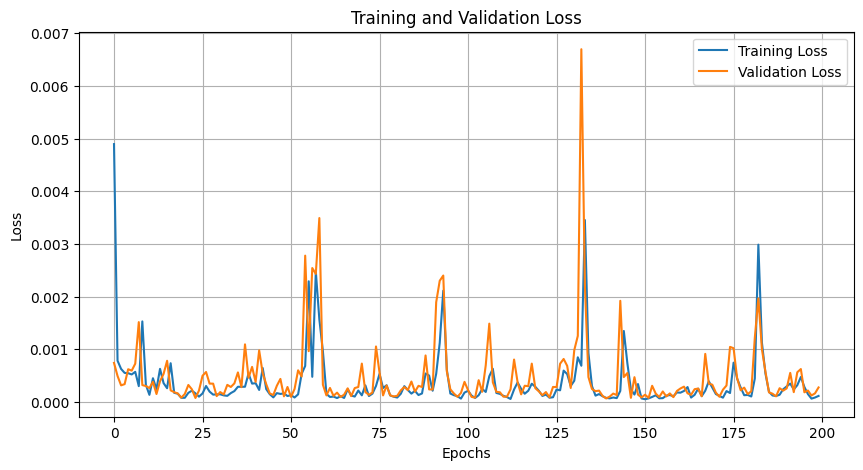

In [28]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. Model Evaluation

Test MSE: 0.0003


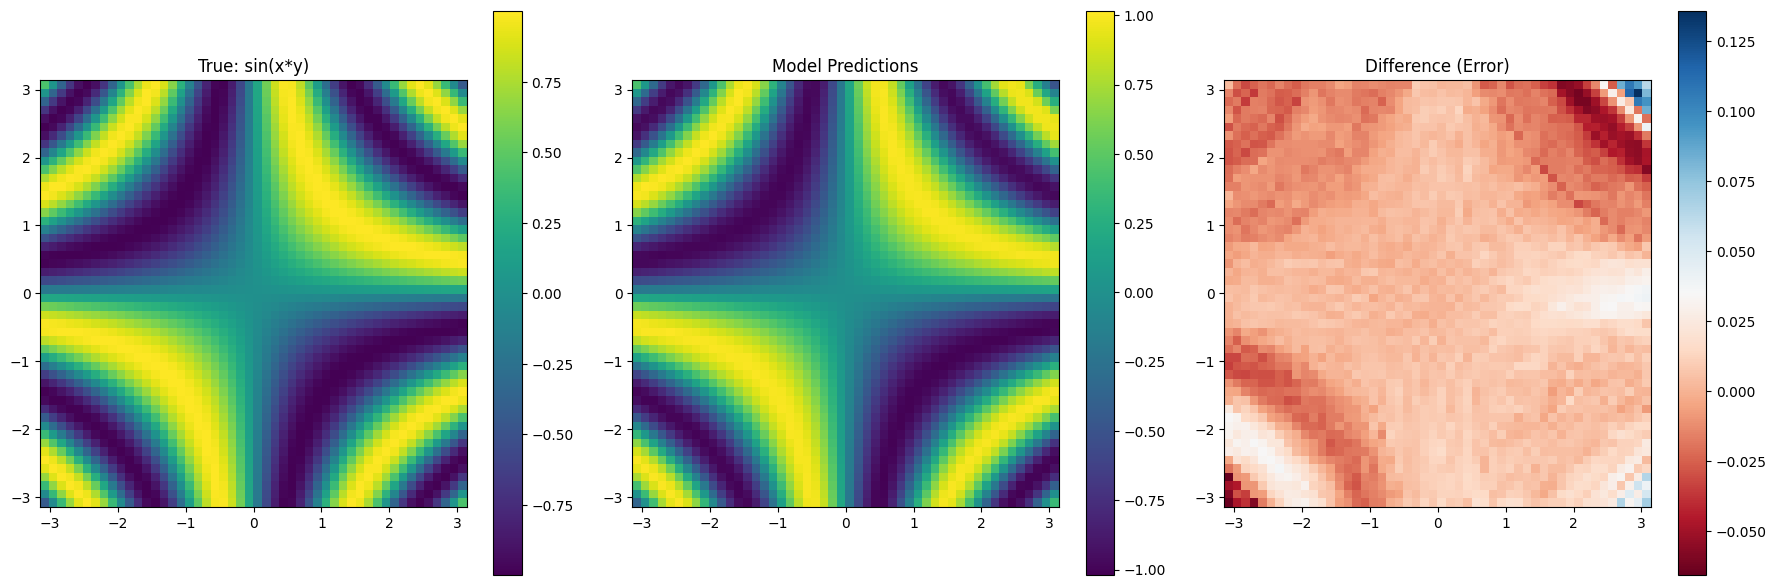

In [29]:
def evaluate_model(model, num_test_points=1000):
    """Evaluate the model on test data and visualize predictions"""
    # Generate test data
    test_inputs, test_targets = generate_data(num_samples=num_test_points)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(test_inputs.to(DEVICE)).cpu().numpy()
    
    # Calculate MSE
    mse = np.mean((predictions - test_targets.numpy()) ** 2)
    print(f'Test MSE: {mse:.4f}')
    
    # Create a grid for visualization
    grid_size = 50
    x = np.linspace(-np.pi, np.pi, grid_size)
    y = np.linspace(-np.pi, np.pi, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Prepare inputs for the model
    grid_inputs = np.column_stack((X.flatten(), Y.flatten()))
    grid_inputs_tensor = torch.tensor(grid_inputs, dtype=torch.float32)
    
    # Make predictions on the grid
    with torch.no_grad():
        grid_predictions = model(grid_inputs_tensor.to(DEVICE)).cpu().numpy()
    
    # Reshape predictions for plotting
    Z_pred = grid_predictions.reshape(grid_size, grid_size)
    
    # Calculate true values
    Z_true = np.sin(X * Y)
    
    # Plot predictions vs true values
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # True function
    im0 = axes[0].imshow(Z_true, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='viridis')
    axes[0].set_title('True: sin(x*y)')
    plt.colorbar(im0, ax=axes[0])
    
    # Model predictions
    im1 = axes[1].imshow(Z_pred, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='viridis')
    axes[1].set_title('Model Predictions')
    plt.colorbar(im1, ax=axes[1])
    
    # Difference (error)
    im2 = axes[2].imshow(Z_true - Z_pred, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='RdBu')
    axes[2].set_title('Difference (Error)')
    plt.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

# Evaluate the trained model
evaluate_model(model)

# Export

In [31]:
import os
import nobuco
from nobuco import ChannelOrder, ChannelOrderingStrategy
from nobuco.layers.weight import WeightLayer

model_name = "sin_model"

export_dir = "./export"
os.makedirs(export_dir, exist_ok=True)

#torch file
torch.save(model, f"{export_dir}/{model_name}_torch.pth")

#keras file
dummy_input = torch.rand(size=(1,2))
keras_model = nobuco.pytorch_to_keras(
    model.eval(),
    args=[dummy_input], kwargs=None,
    inputs_channel_order=ChannelOrder.PYTORCH,
    outputs_channel_order=ChannelOrder.PYTORCH,
)
keras_model.save(f"{export_dir}/{model_name}_keras")

[Nobuco] Tracing (DONE): : 10ops [00:00, 936.96ops/s]
[Nobuco] Converting (DONE): 100%|██████████| 7/7 [00:00<00:00, 361.87ops/s]

Legend:
    Green — conversion successful
    Yellow — conversion imprecise
    Red — conversion failed
    Red — no converter found
    Bold — conversion applied directly
    * — subgraph reused
    Tensor — this output is not dependent on any of subgraph's input tensors
    Tensor — this input is a parameter / constant
    Tensor — this tensor is useless

SinModel[__main__](float32_0<1,2>) -> float32_15<1,1>
 ├· Sequential[torch.nn.modules.container](float32_0<1,2>) -> float32_15<1,1>
 │   │  Linear[torch.nn.modules.linear](float32_0<1,2>) -> float32_3<1,512>
 │   │   └· linear[torch.nn.functional](float32_0<1,2>, float32_1<512,2>, float32_2<512>) -> float32_3<1,512>
 │   │  ReLU[torch.nn.modules.activation](float32_3<1,512>) -> float32_4<1,512>
 │   │   ├· relu[torch.nn.functional](float32_3<1,512>, inplace=False) -> float32_4<1,512>
 │   │   └   └· relu[torch](float32_3<1,512>) -> float32_4<1,512>
 │   │  Linear[torch.nn.modules.linear](float32_4<1,512>) -> float32_7<1,256>
 │   │ 

INFO:tensorflow:Assets written to: ./export/sin_model_keras/assets


INFO:tensorflow:Assets written to: ./export/sin_model_keras/assets


In [32]:
import tensorflow as tf

def representative_data_gen():
    for _ in range(1000):  # Use 100 samples for calibration
        input_value = np.random.uniform(-np.pi, np.pi, size=(2,)).astype(np.float32)  
        yield [input_value]  # Wrap in a list since the model expects batched input
    
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)  # Create a converter
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable optimizations (quantization)
converter.target_spec.supported_types = [tf.int8]  # Limit model to int8
converter.representative_dataset = representative_data_gen  # Use sample data for calibration
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Ensure int8 ops
converter.inference_input_type = tf.int8  # Input tensor type
converter.inference_type = tf.int8  # Internal computation type
converter.inference_output_type = tf.int8  # Output tensor type
# converter.inference_output_type = tf.float32  # Reduce output quantization error

tflite_model = converter.convert()
with open(f"{export_dir}/sin_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpyl84vl6d/assets


INFO:tensorflow:Assets written to: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpyl84vl6d/assets
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-13 22:04:19.278740: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-03-13 22:04:19.278753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-03-13 22:04:19.278892: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/tmpyl84vl6d
2025-03-13 22:04:19.279509: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-13 22:04:19.279516: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/fm/j5zs

In [33]:
interpreter = tf.lite.Interpreter(model_path=f"{export_dir}/{model_name}.tflite")
interpreter.allocate_tensors()


# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for input_detail in input_details:
    print(input_detail)
for output_detail in output_details:
    print(output_detail)

{'name': 'serving_default_args_0:0', 'index': 0, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([1, 2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0246193278580904, 0), 'quantization_parameters': {'scales': array([0.02461933], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 12, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([1, 1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.007931518368422985, 0), 'quantization_parameters': {'scales': array([0.00793152], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [34]:
import os
import json

os.system(f"xxd -i {export_dir}/{model_name}.tflite > {export_dir}/{model_name}.cpp")

pytorch_model_str = repr(model)

input_details_str = json.dumps(input_details[0], indent=2, default=str)
output_details_str = json.dumps(output_details[0], indent=2, default=str)

# Prepend attributes and input/output details to the cpp file
with open(f"{export_dir}/{model_name}.cpp", "r") as f:
    cpp_content = f.read()

cpp_content = cpp_content.replace(f"unsigned char __export_{model_name}_tflite[] ", f"unsigned const char {model_name}[] DATA_ALIGN_ATTRIBUTE")
cpp_content = cpp_content.replace(f"unsigned int __export_{model_name}_tflite_len", f"unsigned const int {model_name}_len")


prepend_content = f'''
#include "{model_name}.h"

// We need to keep the data array aligned on some architectures.
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif
/*
{pytorch_model_str}

Input details:
{input_details_str}

Output details:
{output_details_str}
*/

'''

# Write the modified content back to the file
with open(f"{export_dir}/{model_name}.cpp", "w") as f:
    f.write(prepend_content + cpp_content)


# Create a header file
header_file_content = f'''
#ifndef {model_name.upper()}
#define {model_name.upper()}

extern const unsigned char {model_name}[];
extern const unsigned int {model_name}_len;

#endif      
'''
with open(f"{export_dir}/{model_name}.h", "w") as f:
    f.write(header_file_content)


In [37]:



#get quantization parameters from input details
input_scale = input_details[0]['quantization_parameters']['scales'][0]
input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]
print("input scale,zero: ", input_scale, input_zero_point)

input_float = np.random.uniform(-np.pi, np.pi, size=2)

# input_quantized = np.round(input_float / input_scale + input_zero_point).astype(np.int8)
input_quantized = np.clip(np.round(input_float / input_scale + input_zero_point), -128, 127).astype(np.int8)

input_quantized = input_quantized.reshape((1,2))

interpreter.set_tensor(input_details[0]['index'], input_quantized)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the quantization parameters from the output details
output_scale = output_details[0]['quantization_parameters']['scales'][0]
output_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]
print("output scale,zero: ", output_scale, output_zero_point)


# Apply dequantization formula: real_value = (quantized_value - zero_point) * scale
output_data_float = (output_data.astype(np.float32) - output_zero_point) * output_scale

x,y = input_float
true_val = np.sin(x*y)
print(f"Evaluating sin({x:.3f}*{y:.3f})")
print("Real value:", true_val)

pre_quant = keras_model.predict(input_float.reshape((1,2)), verbose=0)
print("Prequant: ", pre_quant.flatten()[0])


# print("Int8 output:", output_data)
print("Quantized output:", output_data_float.flatten()[0])
# print(f"Total Error: {true_val - output_data_float}")

print("Model error: ", true_val - pre_quant)
print("Quantization error total:", pre_quant - output_data_float)

input_test = np.clip(np.round(input_float / input_scale + input_zero_point), -128, 127).astype(np.int8)
input_test = (input_test - input_zero_point) * input_scale
output_test = np.sin(input_test[0]+input_test[1])
print("Quantization error input:", true_val - output_test)

# dequantized = (output_test - output_zero_point) * output_scale





input scale,zero:  0.024619328 0
output scale,zero:  0.007931518 0
Evaluating sin(-1.510*0.464)
Real value: -0.6441404362074101
Prequant:  -0.649144
Quantized output: -0.6503845
Model error:  [[0.00500357]]
Quantization error total: [[0.00124049]]
Quantization error input: 0.21521698042238113


Torch error from true: -0.066 to 0.136
TFLite error from true: -0.104 to 0.121


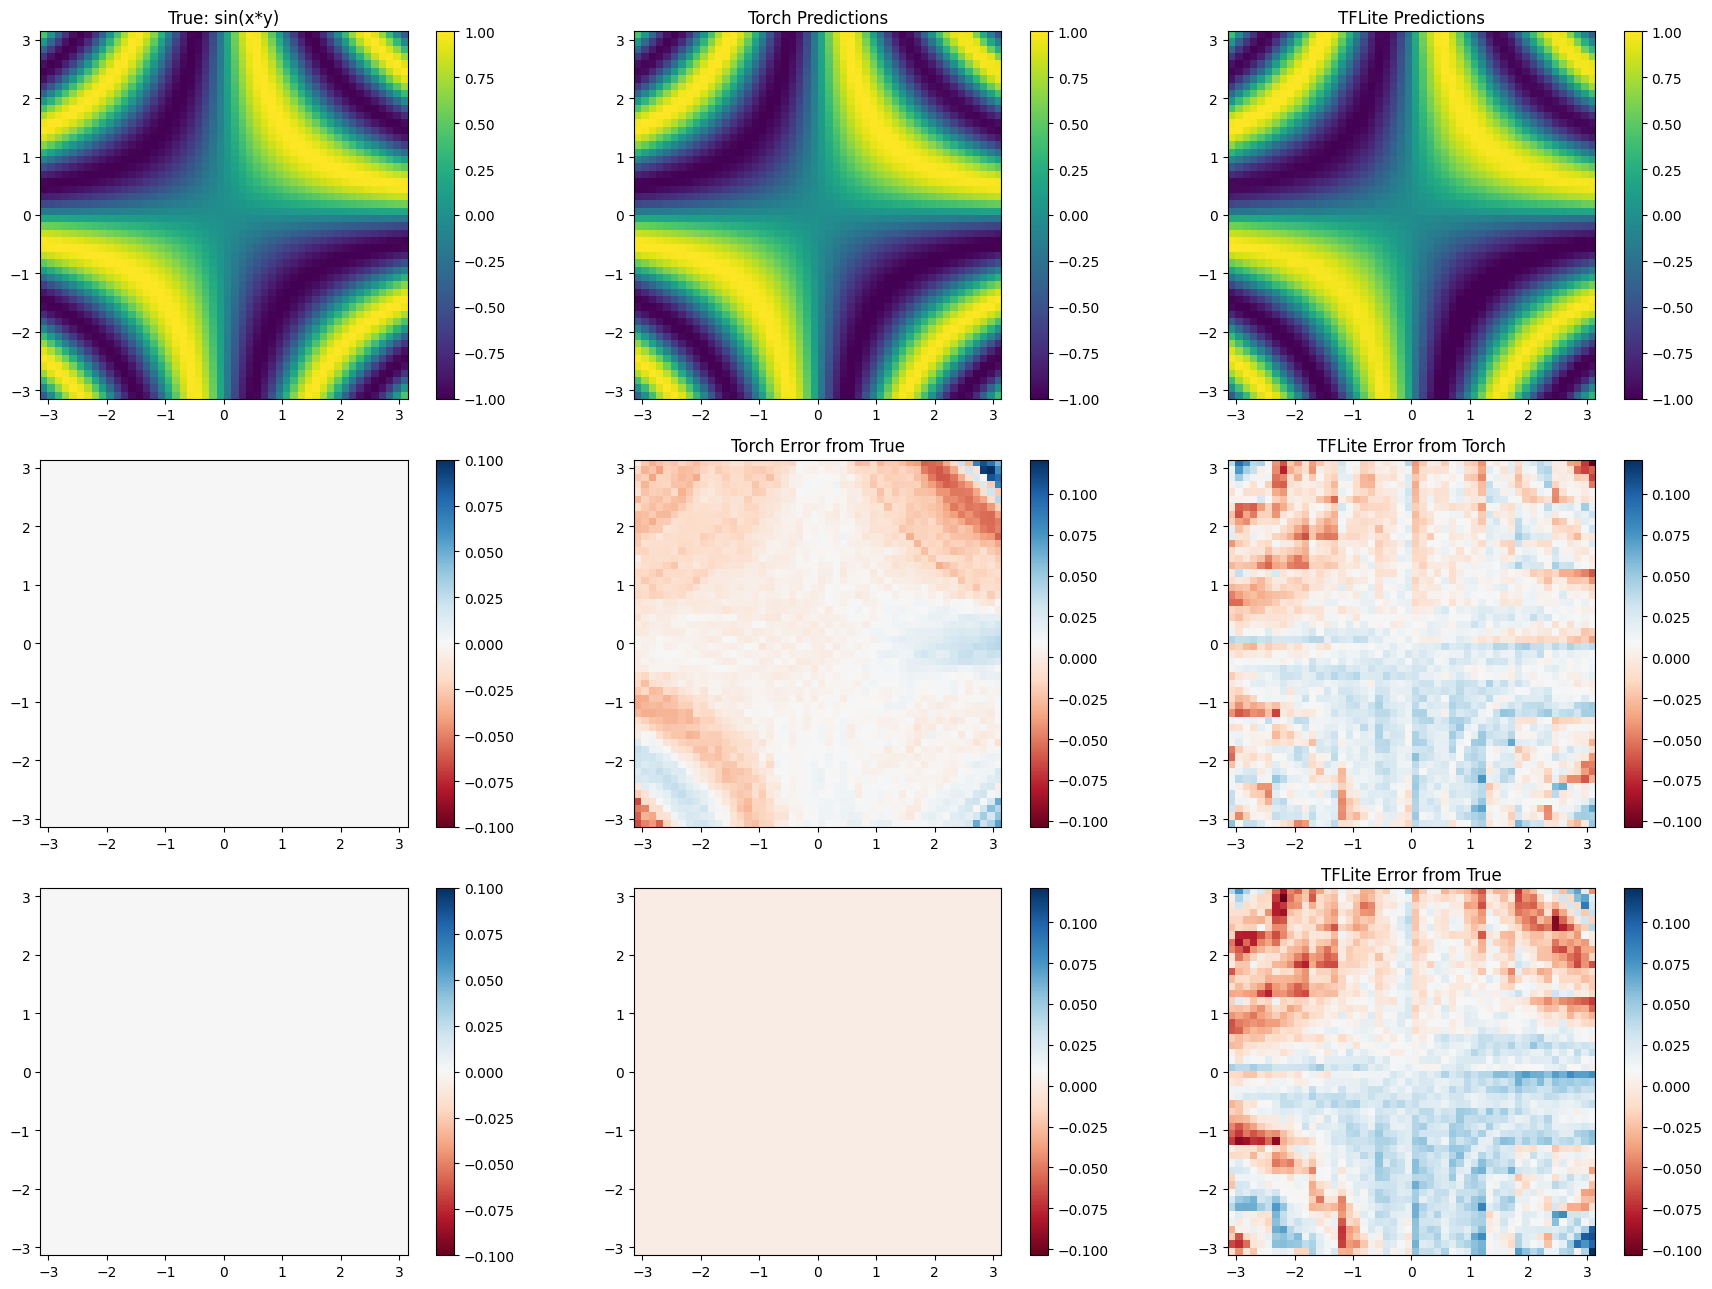

In [38]:
# Create a grid for visualization
grid_size = 50
border = 0.0
x = np.linspace(-np.pi+border, np.pi-border, grid_size)
y = np.linspace(-np.pi+border, np.pi-border, grid_size)
X, Y = np.meshgrid(x, y)

# Prepare inputs for the model
grid_inputs = np.column_stack((X.flatten(), Y.flatten()))
grid_inputs_tensor = torch.tensor(grid_inputs, dtype=torch.float32)

# Calculate true values
Z_true = np.sin(X * Y)

# Make torch predictions on the grid
with torch.no_grad():
    grid_predictions = model(grid_inputs_tensor.to(DEVICE)).cpu().numpy()
Z_torch = grid_predictions.reshape(grid_size, grid_size)

# Prepare inputs for TFLite interpreter
grid_inputs_int8 = np.clip(np.round(grid_inputs / input_scale + input_zero_point), -128, 127).astype(np.int8)
tflite_predictions = []
for i in range(len(grid_inputs)):
    interpreter.set_tensor(input_details[0]['index'], grid_inputs_int8[i:i+1])
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_float = (output_data.astype(np.float32) - output_zero_point) * output_scale
    tflite_predictions.append(output_float[0][0])
Z_tflite = np.array(tflite_predictions).reshape(grid_size, grid_size)

# Plot predictions vs true values
fig, axes = plt.subplots(3, 3, figsize=(18, 13))


vmin = -1
vmax = 1
vmin_err_torch = np.min(Z_true - Z_torch)
vmax_err_torch = np.max(Z_true - Z_torch)
print(f"Torch error from true: {vmin_err_torch:.3f} to {vmax_err_torch:.3f}")   

vmin_err_tflite = np.min(Z_true - Z_tflite)
vmax_err_tflite = np.max(Z_true - Z_tflite)
print(f"TFLite error from true: {vmin_err_tflite:.3f} to {vmax_err_tflite:.3f}")


# True function
im0 = axes[0,0].imshow(Z_true, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axes[0,0].set_title('True: sin(x*y)')
plt.colorbar(im0, ax=axes[0,0])
diff0 = axes[1,0].imshow(Z_true - Z_true, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='RdBu')
plt.colorbar(diff0, ax=axes[1,0])
diff0 = axes[2,0].imshow(Z_true - Z_true, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='RdBu')
plt.colorbar(diff0, ax=axes[2,0])

# Torch
im1 = axes[0,1].imshow(Z_torch, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axes[0,1].set_title('Torch Predictions')
plt.colorbar(im1, ax=axes[0,1])
diff1 = axes[1,1].imshow(Z_true - Z_torch, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='RdBu', vmin=vmin_err_tflite, vmax=vmax_err_tflite)
axes[1,1].set_title('Torch Error from True')
plt.colorbar(diff1, ax=axes[1,1])
diff1 = axes[2,1].imshow(Z_torch - Z_torch, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='RdBu', vmin=vmin_err_tflite, vmax=vmax_err_tflite)
plt.colorbar(diff1, ax=axes[2,1])

# TFLite 
im2 = axes[0,2].imshow(Z_tflite, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axes[0,2].set_title('TFLite Predictions')
plt.colorbar(im2, ax=axes[0,2])
diff2true = axes[1,2].imshow(Z_torch - Z_tflite, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='RdBu', vmin=vmin_err_tflite, vmax=vmax_err_tflite)
axes[1,2].set_title('TFLite Error from Torch')
plt.colorbar(diff2true, ax=axes[1,2])
diff2torch = axes[2,2].imshow(Z_true - Z_tflite, extent=[-np.pi, np.pi, -np.pi, np.pi], origin='lower', cmap='RdBu', vmin=vmin_err_tflite, vmax=vmax_err_tflite)
axes[2,2].set_title('TFLite Error from True')
plt.colorbar(diff2torch, ax=axes[2,2])


plt.tight_layout()
plt.show()

In [16]:
#test
test_input = np.array([1,2], dtype=np.int8).reshape((1,2))
interpreter.set_tensor(input_details[0]['index'], test_input)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data

array([[-3]], dtype=int8)

## 6. Export to ONNX (unused)

The ONNX format allows us to deploy our model in various environments and frameworks.

In [14]:
def export_to_onnx(model, filename='sin_model.onnx'):
    """Export the trained model to ONNX format"""
    # Create a dummy input tensor with the correct shape
    dummy_input = torch.randn(1, INPUT_SIZE, device=DEVICE)
    
    # Export the model
    torch.onnx.export(
        model,                       # model being run
        dummy_input,                 # model input (or a tuple for multiple inputs)
        filename,                    # where to save the model
        export_params=True,          # store the trained parameter weights inside the model file
        opset_version=12,            # the ONNX version to export the model to
        do_constant_folding=True,    # whether to execute constant folding for optimization
        input_names=['input'],       # the model's input names
        output_names=['output'],     # the model's output names
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"Model exported to {filename}")

# Export the model to ONNX
export_to_onnx(model)

Model exported to sin_model.onnx
